# Trading Volume Forecasting with a Residual GRU

This notebook explores one-day-ahead trading volume forecasting using a time series dataset with 320 latent features.
Each observation contains **320 latent features** derived from the original time series and **the next-day trading volume as the prediction target**.

## Baseline and Initial Modeling Hypotheses

Based on the ACF and PACF (01_eda.ipynb), the series shows strong autocorrelation, 
suggesting that a simple persistence forecast could already be a strong baseline.
I therefore started with a persistence baseline and three initial modeling approaches.

All models are evaluated under the same rolling-origin backtesting setup to avoid leakage and to reflect realistic forecasting conditions.

The baseline and model variants are defined as follows:
- **Baseline (P):** $\hat{y}_{t+1} = y_t$

- **Model A:** $\hat{y}_{t+1} = f(y_{t-w+1:t})$  
Uses only past target values.

- **Model B:** $\hat{y}_{t+1} = f(y_{t-w+1:t}, X_{t-1})$  
Adds the most recent covariate vector.

- **Model C:** $\hat{y}_{t+1} = f(y_{t-w+1:t}, X_{t-w+1:t-1})$  
Uses the full covariate history within the input window.

Here, $w$ denotes the input window size, 
i.e., the number of past time steps provided to the model.


#### Reproducibility
For reproducibility, random seeds are fixed throughout the experiments.
Data loading is handled by a helper function that separates the target and covariates, selects numeric features, and optionally applies a $log(1 + y)$ transformation.
This keeps preprocessing consistent across all models.

In [2]:
from src.config import SEED, set_seeds
from src.data import load_time_series_csv

#### Sample indexing and leakage-safe split
To avoid leakage in the time series setting, samples are indexed by their input end time $t$ and target time $t+h$.
In this project, $h = 1$, corresponding to one-step-ahead forecasting. The train, validation, and test splits are performed based on the target time, not the input time.
This ensures that validation and test targets never leak into the training set during rolling-origin evaluation.

In [3]:
from src.data import build_sample_index, split_samples_by_target_time

#### Feature scaling
The covariates are standardized using a StandardScaler to avoid instability caused by different feature scales.
The scaler is fitted only on the training portion of each fold and then applied to validation and test data, preventing leakage of future information.

In [4]:
from src.data import fit_x_scaler

#### Baseline (Persistence)
As a starting point, I use a simple persistence baseline, which predicts the next value as the current one: $\hat{y}_{t+1} = y_t$.
The ACF analysis showed strong autocorrelation, suggesting that the most recent observation already contains substantial predictive information.

In [5]:
from src.models import predict_persistence

### Input construction for models A, B, and C

#### Sequence generation
To test the three initial modeling approaches, the input sequences are constructed for each case. All models use a rolling window of past observations that ends at time $t$, and the prediction target is the next value $y_{t+1}$.

The difference between the models lies in how much additional information is provided:
- Model A uses only the past values of the target.
- Model B adds the most recent covariate vector $X_{t-1}$.
- Model C uses the full covariate history within the window.

This setup makes it possible to compare the incremental value of the covariates. Each model receives the same target history, and only the amount of covariate information changes.

In [6]:
from src.data import make_case_A, make_case_B, make_case_C

#### Applying the train/validation/test split
After constructing the input sequences, the data is split into training, validation, and test sets using the leakage-safe masks defined earlier.

Since the models use different input structures, separate helper functions are used:
- A single-input version for Model A.
- A two-branch version for Model B, where the target history and the most recent covariates are handled separately.
- A two-sequence version for Model C, where both the target and covariates are treated as time series.

These helpers simply apply the same time-based split to the different input formats, keeping the evaluation consistent across all models.

In [7]:
from src.data import apply_split_single, apply_split_two_now, apply_split_two_seq

#### GRU model architectures for A, B, and C
To keep the comparison consistent, all approaches use compact GRU-based models with similar capacity.
The key difference is how the inputs are handled.
- Model A uses a single GRU that reads only the target history $y_{t-w+1:t}$.
- Model B uses a two-branch architecture: a GRU for the target history and a small dense branch for the most recent covariates $X_{t-1}$. The two representations are then concatenated before the final prediction layer.
- Model C also uses two branches, but treats covariates as a time series. Both the target history and covariate history are encoded with GRUs and then combined.

All covariate inputs stop at $t-1$, ensuring that no information from the prediction time $t+1$ is used.

In [8]:
from src.models import build_gru_single, build_gru_two_branch_now, build_gru_two_branch_seq

### Training and evaluation
Models are trained with early stopping based on validation loss.
This keeps each fold efficient and helps prevent overfitting within the rolling-origin setup.

Evaluation is reported both in the model space and on the original scale.
Training is performed on $\log(1+y)$, so model-space metrics reflect the optimization objective, while inverse-transformed metrics are easier to interpret in terms of trading volume.

In [9]:
from src.training import train_single, train_two_now, train_two_seq
from src.evaluation import eval_predictions

### Rolling-origin backtesting setup

#### Rolling-origin splits (expanding window)
To reflect a realistic forecasting scenario, the models are evaluated using a rolling-origin backtest with an expanding training window.
In each fold, the model is trained on the past, validated on the most recent portion of the training period, and tested on the next unseen block of time. After each fold, the training window expands and the process repeats. This setup is that predictions are always made using only past information.

#### Backtest runner (training and evaluation loop)
The backtest loop constructs leakage-safe splits, trains the selected model, and evaluates predictions on the next unseen block.
Two details ensure a fair evaluation:
- The split is performed using the target time $t+1$, so validation and test targets never appear in the training set.
- The feature scaler for $X$ is fitted only on pure training rows, preventing any leakage from validation or test data.
For visualization, artifacts from a single fold (such as the loss curve and test predictions) are optionally stored.

In [10]:
from src.backtest import run_backtest

### Running the baseline and initial models

Let's run the persistence baseline and the three initial models under the same rolling-origin backtesting setup.

The configuration is:
- Forecast horizon: one step ahead.
- Input window: 7 time steps.
- Initial training period: first 500 observations.
- Test block size: 50 observations per fold.
- Validation size: last 100 observations of each training period.

All models are evaluated under exactly the same splits to ensure a fair comparison.

In [11]:
import pandas as pd
from src.config import WINDOW, HORIZON, USE_LOG1P, INITIAL_TRAIN_SIZE, TEST_BLOCK_SIZE, VAL_SIZE, PLOT_FOLD

df, X_raw, y_raw, y_model, cov_cols, date_col, target_col = load_time_series_csv(
    use_log1p=USE_LOG1P)

cases = ["P", "A", "B", "C"]

results = []
artifacts_all = {}

for case in cases:
    need_artifacts = case in ["P", "A"]

    out = run_backtest(
        df=df,
        X_raw=X_raw,
        y_model=y_model,
        window=WINDOW,
        horizon=HORIZON,
        use_log1p=USE_LOG1P,
        case_name=case,
        initial_train_size=INITIAL_TRAIN_SIZE,
        test_block_size=TEST_BLOCK_SIZE,
        val_size=VAL_SIZE,
        plot_fold=PLOT_FOLD if need_artifacts else None,
        return_artifacts=need_artifacts,
        seed=SEED,
    )

    if need_artifacts:
        bt, art = out
        artifacts_all[case] = art
    else:
        bt = out

    bt["case"] = case
    results.append(bt)

all_results = pd.concat(results, ignore_index=True)
# print(all_results.head(20))

summary = (
    all_results
    .groupby("case")
    .mean(numeric_only=True)
    .drop(columns=["fold", "train_end_row", "n_test_samples"], errors="ignore")
    .sort_values("RMSE_model")
)

print(summary)

      RMSE_model  MAE_model  R2_model     RMSE_orig      MAE_orig
case                                                             
P       0.576366   0.456488 -0.044397  6.562690e+07  4.445314e+07
A       0.721198   0.591038 -0.692154  8.071759e+07  5.834378e+07
C       0.752540   0.622876 -0.819655  8.262815e+07  6.345993e+07
B       0.879160   0.735729 -2.262917  1.492381e+08  1.124836e+08


Across the rolling origin backtest, the persistence baseline (P) is the strongest and most stable reference point.
The GRU models (A, B, C) do not outperform it in this setting. Model B performs worst, and even Model C, despite using richer input information, does not surpass Model A.

This result is consistent with the earlier autocorrelation analysis: when the series is highly persistent, simply using the last observed value already captures much of the short-term predictability.
In this setting, the main challenge is not increasing model complexity, but finding signal that goes beyond persistence.

### Example fold: training dynamics and predictions

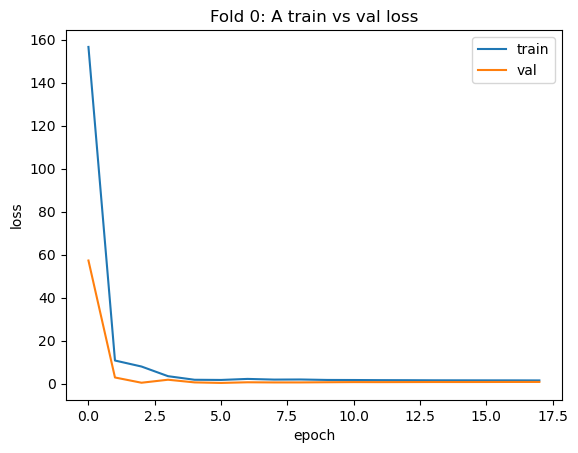

In [12]:
import numpy as np
from src.plots import plot_loss_curve, plot_test_predictions_overlay

artA = artifacts_all["A"]
artP = artifacts_all["P"]

# sanity check
assert np.array_equal(artA["A_target_index"], artP["P_target_index"])
assert np.allclose(artA["A_y_true_model"], artP["P_y_true_model"])

artifacts_PA = {**artA, **artP}

plot_loss_curve(
    artifacts_PA["A_history"],
    title=f"Fold {PLOT_FOLD}: A train vs val loss"
)

To better understand how the GRU model learns, I plot the training and validation loss for one representative fold.
The curves drop rapidly during the first few epochs and then stabilize, indicating that the model converges quickly.
The training and validation losses follow a similar trajectory, suggesting that the model is not severely overfitting in this setting.

Overall, the learning dynamics appear stable, so any performance differences compared to the persistence baseline are likely due to the the structure rather than unstable training.

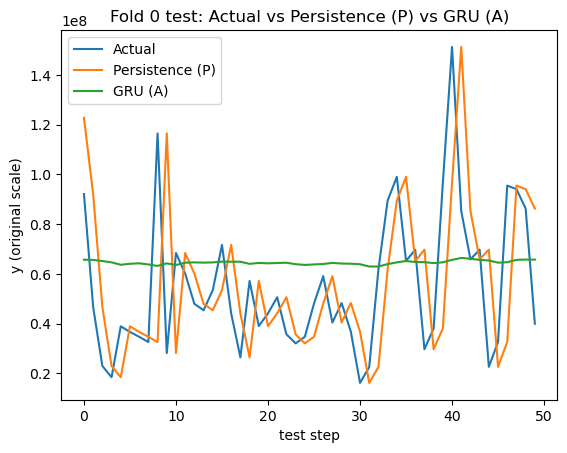

In [13]:
plot_test_predictions_overlay(
    artifacts_PA,
    use_log1p=USE_LOG1P,
    title=f"Fold {PLOT_FOLD} test: Actual vs Persistence (P) vs GRU (A)"
)

To better understand how the models behave, I compare the actual values, the persistence baseline, and the GRU predictions on the same test block.
The persistence forecast closely follows the short-term movements of the series, since it simply carries the last observation forward.
In contrast, the GRU model produces a much smoother trajectory and reacts more slowly to sudden spikes or drops.

This visual comparison helps explain the earlier numerical results.
Even though the GRU is more flexible, it struggles to outperform the simple persistence rule in a series dominated by strong short-term autocorrelation.

## Model redesign: residual forecasting
After evaluating the initial models, a clear pattern emerged.
All learned models struggled to outperform the simple persistence baseline, even when additional covariates or longer histories were introduced.

The ACF analysis showed strong short-term autocorrelation, meaning that much of the next-day behavior is already captured by simply carrying the most recent value forward. This suggests that the main challenge is not predicting the full level of the series, but modeling the deviation from this persistence structure. The target variable is modeled in log space: $y_t^{(\text{model})} = \log(1 + y_t)$

Instead of predicting the next level directly, the problem is reformulated as a residual forecasting task in this transformed space.
For each time step, the input remains the recent target history: $y_{t-w+1:t}^{(\text{model})}$

The model is trained to predict the one-step-ahead residual: $r_{t+1}^{(\text{model})} = y_{t+1}^{(\text{model})} - y_t^{(\text{model})}$

The final forecast is then reconstructed as: $\hat y_{t+1}^{(\text{model})} = y_t^{(\text{model})} + \hat r_{t+1}^{(\text{model})}$

This formulation keeps the strong persistence structure intact while allowing the neural network to focus only on short-term deviations. Rather than learning the entire signal from scratch, the model concentrates on the component that persistence alone cannot explain.

### Residual input and target construction
The residual dataset is constructed by taking the recent target history as input and computing the one-step-ahead residual as the prediction target.
After the sequences are built, the rolling-origin masks are applied to create leakage-safe training, validation, and test splits.

In [14]:
from src.data import make_case_residual, apply_split_residual

### Residual GRU model
To implement this idea, the GRU architecture was redesigned to predict residuals directly.
Instead of predicting the next value from scratch, the model starts from the last observed value and learns only the adjustment needed for the next step.

Formally, the model operates in log space: $\hat y_{t+1}^{(\text{model})} = y_t^{(\text{model})} + g\!\left(y_{t-w+1:t}^{(\text{model})}
\right)$,

where $g(\cdot)$ is a GRU-based network that outputs the residual in model space.
Predictions are then mapped back to the original scale via the inverse transformation.

This setup has two practical benefits:
- The persistence signal is built directly into the prediction, which is useful when autocorrelation is high.
- The learning problem becomes simpler, since the network only models short term deviations instead of the full level of the series.

In [15]:
from src.models import build_gru_delta

### Rolling-origin backtest (residual setting)
It runs the same rolling-origin evaluation as in Chapter 2, but under the residual formulation.
The split logic, training procedure, and metrics remain unchanged.


In [16]:
from src.backtest import run_backtest_residual

###  Running the residual experiment

In [17]:
cases = ["P", "Res"]

results_res = []
artifacts_res = {}

for case in cases:
    out = run_backtest_residual(
        df=df,
        y_model=y_model,
        window=WINDOW,
        horizon=HORIZON,
        use_log1p=USE_LOG1P,
        initial_train_size=INITIAL_TRAIN_SIZE,
        test_block_size=TEST_BLOCK_SIZE,
        val_size=VAL_SIZE,
        case_name=case,
        plot_fold=PLOT_FOLD,
        return_artifacts=True,
        seed=SEED,
    )

    bt, art = out
    artifacts_res[case] = art

    bt["case"] = case
    results_res.append(bt)

all_results_res = pd.concat(results_res, ignore_index=True)

summary_res = (
    all_results_res
    .groupby("case")
    .mean(numeric_only=True)
    .drop(columns=["fold", "train_end_row", "n_test_samples"], errors="ignore")
    .sort_values("RMSE_model")
)

print(summary_res)

      RMSE_model  MAE_model  R2_model     RMSE_orig      MAE_orig
case                                                             
Res     0.560256   0.444160  0.010705  6.296072e+07  4.301467e+07
P       0.576366   0.456488 -0.044397  6.562690e+07  4.445314e+07


Across the rolling-origin backtest, the residual model (Res) consistently outperforms the persistence model (P).
Once the strong persistence structure is handled directly, the neural network is able to learn meaningful short-term deviations and achieve a modest but stable improvement.

### Example fold: training dynamics and predictions

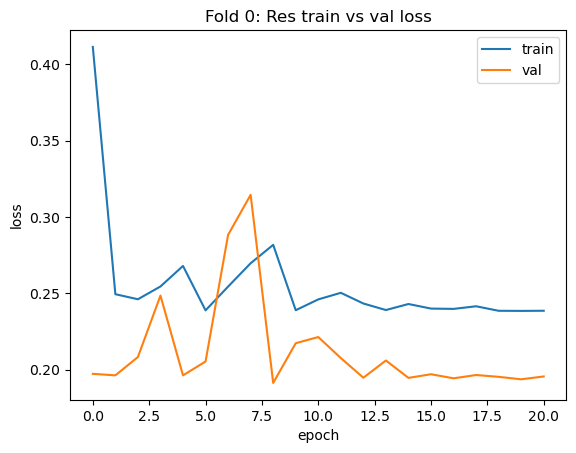

In [18]:
art_Res = artifacts_res["Res"]
art_P = artifacts_res["P"]

# sanity check
assert np.array_equal(art_Res["Res_target_index"], art_P["P_target_index"])
assert np.allclose(art_Res["Res_y_true_model"], art_P["P_y_true_model"])
artifacts_res = {**art_Res, **art_P}

plot_loss_curve(
    artifacts_res["Res_history"],
    title=f"Fold {PLOT_FOLD}: Res train vs val loss"
)

The training and validation losses follow a similar trend and remain close throughout training.
This indicates that the residual GRU trains in a stable manner and does not show signs of severe overfitting within each fold.

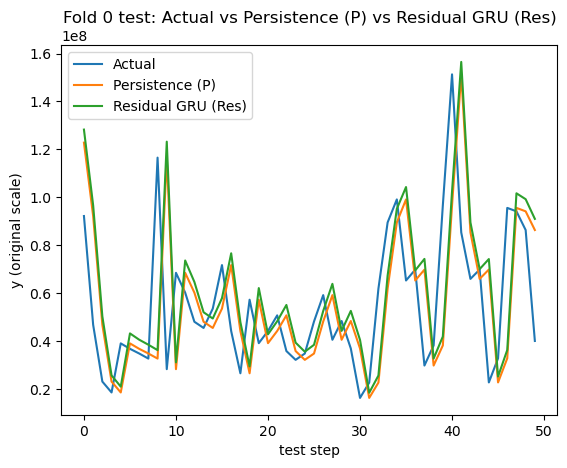

In [19]:
from src.plots import plot_test_predictions_overlay_residual

plot_test_predictions_overlay_residual(
    artifacts_res,
    use_log1p=True,
    title=f"Fold {PLOT_FOLD} test: Actual vs Persistence (P) vs Residual GRU (Res)"
)

On the test block, both models follow the overall level of the series, which is expected given the strong persistence in the data.
However, the residual GRU makes small local adjustments to the persistence forecast, bringing the predictions slightly closer to the actual values.

These adjustments are modest, but consistent with the quantitative results, where the residual model achieves lower RMSE and MAE than the persistence model.
This suggests that modeling the residual signal allows the network to capture short-term deviations that persistence alone cannot explain.

## Summary

This project investigated one-day-ahead trading volume forecasting using GRU-based models and latent time series features.
The initial objective was to build increasingly expressive models that could outperform a simple persistence baseline.

However, the rolling-origin backtests revealed a clear pattern:
the persistence model was already a strong and stable predictor, and none of the direct GRU models (A, B, C) were able to outperform it.
This was consistent with the autocorrelation analysis, which indicated strong short-term persistence in the series.

This suggested that the main difficulty was not model capacity, but the problem formulation itself.
The task was therefore reformulated as a residual forecasting problem in log space: 

$y_t^{(\text{model})} = \log(1 + y_t),$

$r_{t+1}^{(\text{model})} = y_{t+1}^{(\text{model})} - y_t^{(\text{model})}$.

The final prediction is reconstructed as 
$\hat y_{t+1}^{(\text{model})} = y_t^{(\text{model})} + \hat r_{t+1}^{(\text{model})}$.

Under this formulation, the residual model consistently performed better than the baseline across rolling-origin folds.
A multi-seed robustness check (Appendix) showed that this improvement was stable across different random initializations.

**Key insight:**  
In highly persistent time series, increasing model complexity may be less effective than reformulating the prediction task.
The residual approach turned out to be more reliable than deeper or more complex GRU architectures.